In [1]:
from bs4 import BeautifulSoup 
import pandas as pd
# pd.options.display.max_rows = 1000
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
sns.set(style='whitegrid');

In [5]:
# virus stats api
api = 'https://lab.isaaclin.cn/nCoV/api/overall'
# api_backup = https://www.tianqiapi.com/api?version=epidemic&appid=23035354&appsecret=8YvlPNrz
# parameter to get all historical number since 1/24/2020
par = {'latest': '0'}
result = requests.get(api, params=par)
result.status_code

200

In [6]:
data = result.json()
last_update = datetime.fromtimestamp(data['results'][0]['updateTime']//1000).strftime("%Y-%m-%d %H:%M:%S")
print('last update time {}'.format(last_update))

last update time 2020-02-12 22:22:06


In [7]:
# get key info of report
date = []
confirmedCount = []
suspectedCount = []
curedCount = []
deadCount = []
seriousCount = []
suspectedIncr = []
confirmedIncr = []
curedIncr = []
seriousIncr = []

for i in range(len(data['results'])):
#     print(i)
    date.append(datetime.fromtimestamp(data['results'][i]['updateTime']//1000).strftime("%Y-%m-%d %H:%M:%S"))
    confirmedCount.append(data['results'][i]['confirmedCount'])
    suspectedCount.append(data['results'][i]['suspectedCount'])
    curedCount.append(data['results'][i]['curedCount'])
    deadCount.append(data['results'][i]['deadCount'])
    # this data didn't exist in older daily count
    try:
        seriousCount.append(data['results'][i]['seriousCount'])
        suspectedIncr.append(data['results'][i]['suspectedIncr'])
        confirmedIncr.append(data['results'][i]['confirmedIncr'])
        curedIncr.append(data['results'][i]['curedIncr'])
        seriousIncr.append(data['results'][i]['seriousIncr'])
    except KeyError:
        seriousCount.append(0)
        suspectedIncr.append(0)
        confirmedIncr.append(0)
        curedIncr.append(0)
        seriousIncr.append(0)

In [8]:
# put all info into one df
df_millisecond = pd.DataFrame(list(zip(date, confirmedCount, suspectedCount, curedCount, deadCount, seriousCount, suspectedIncr, confirmedIncr, curedIncr, seriousIncr)),
                 columns=['date', 'confirmedCount', 'suspectedCount', 'curedCount', 'deadCount', 'seriousCount', 'suspectedIncr', 'confirmedIncr', 'curedIncr', 'seriousIncr'])
df_millisecond['date'] = pd.to_datetime(df_millisecond['date'])

In [9]:
df_millisecond.head()

,date,confirmedCount,suspectedCount,curedCount,deadCount,seriousCount,suspectedIncr,confirmedIncr,curedIncr,seriousIncr
0,2020-02-12 22:22:06,59883,16067,5928,1368,8204,0,0,0,0
1,2020-02-12 22:20:00,59883,16067,5928,1368,0,0,0,0,0
2,2020-02-12 22:14:44,59883,16067,5928,1368,8204,0,0,0,0
3,2020-02-12 21:55:45,59883,16067,5928,1367,0,0,0,0,0
4,2020-02-12 21:51:31,59883,16067,5922,1367,8204,0,0,0,0


In [11]:
# create another df show data by day
day_name = df_millisecond['date'].dt.day.unique() 
ix_lastUpdate = []
for day in day_name:
    try:
        last_update_time = df_millisecond[(df_millisecond['date'].dt.day==day)&
                                         # suspecte incr data is not updated on each row
                                          (df_millisecond['suspectedIncr']!=0)]['date'].max()
        ix = df_millisecond[df_millisecond['date'] == last_update_time].index.values[0]
    except IndexError:
        last_update_time = df_millisecond[(df_millisecond['date'].dt.day==day)]['date'].max()
        ix = df_millisecond[df_millisecond['date'] == last_update_time].index.values[0]
    ix_lastUpdate.append(ix)

In [12]:
# reset dataframe format
# number by the end of day
df_day = df_millisecond.iloc[ix_lastUpdate]
df_day['date'] = df_day['date'].dt.date

# reset index as date to facilitate calculation
df_day.index = df_day['date']
# set this to string to facilitate plot 
# df_day['date'] = df_day['date'].astype(str)
df_day.sort_index(inplace=True)
# add death and cure rate
df_day['deathRate'] = round(df_day['deadCount']/df_day['confirmedCount'],4)
df_day['cureRate'] = round(df_day['curedCount']/df_day['confirmedCount'], 4)

/Users/jonzhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jonzhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/jonzhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

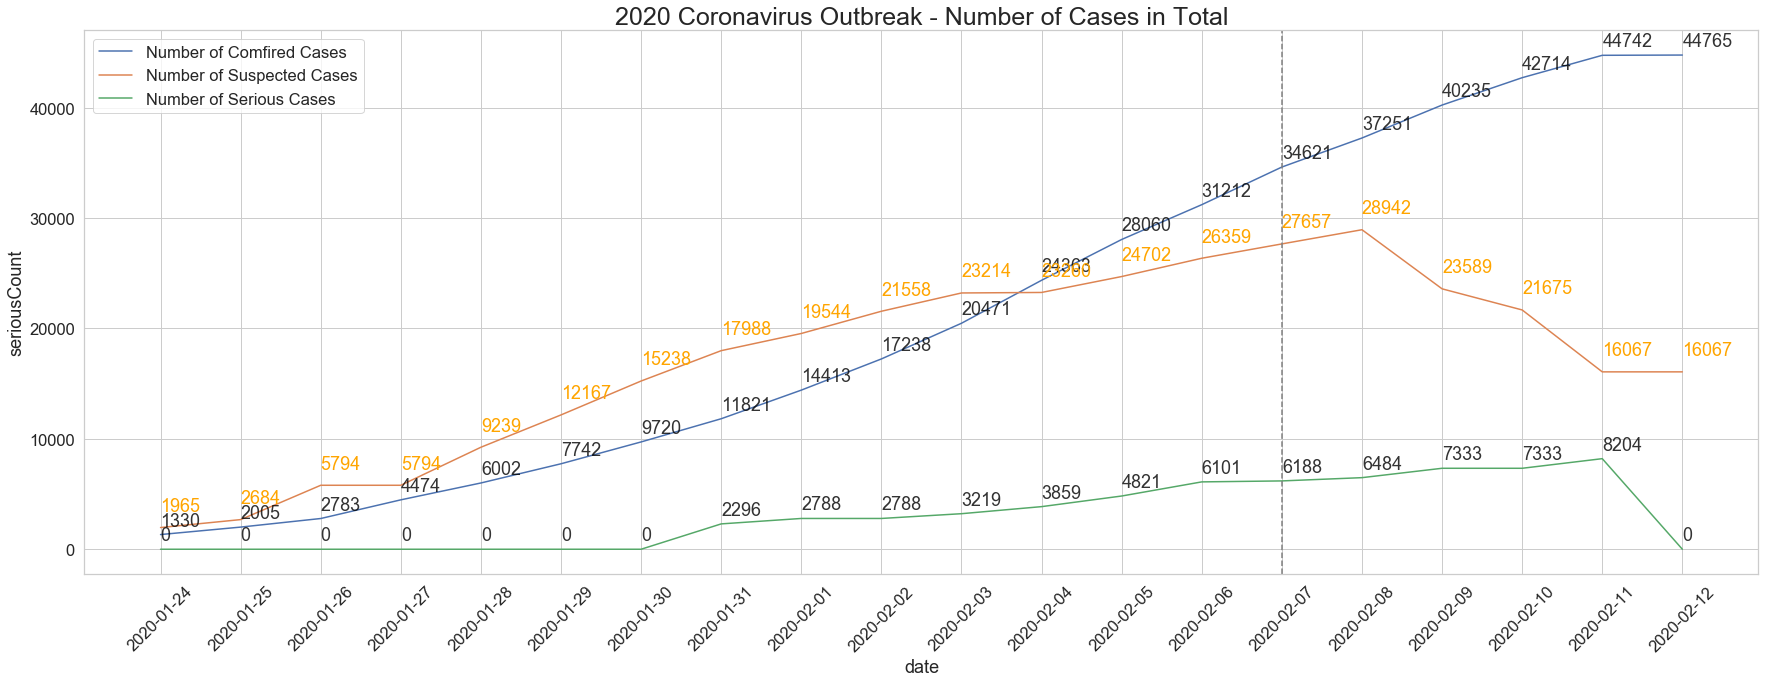

In [14]:
#plot
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_day['date'].astype(str), y=df_day['confirmedCount'], ax=ax1, label = 'Number of Comfired Cases').set_title('2020 Coronavirus Outbreak - Number of Cases in Total', fontsize=25)
sns.lineplot(x=df_day['date'].astype(str), y=df_day['suspectedCount'], ax=ax1, label = 'Number of Suspected Cases')
sns.lineplot(x=df_day['date'].astype(str), y=df_day['seriousCount'], ax=ax1, label = 'Number of Serious Cases')
# add data label
[ax1.text(p[0], p[1]+800, p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['confirmedCount'])]
[ax1.text(p[0], p[1]+1500, p[1], color='orange', alpha=1) for p in zip(ax1.get_xticks(), df_day['suspectedCount'])]
[ax1.text(p[0], p[1]+800, p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['seriousCount'])];
# 14 days lag of outbreak
ax1.axvline(str(df_day['date'][0] + timedelta(days=14)),color='grey', linestyle = '--');

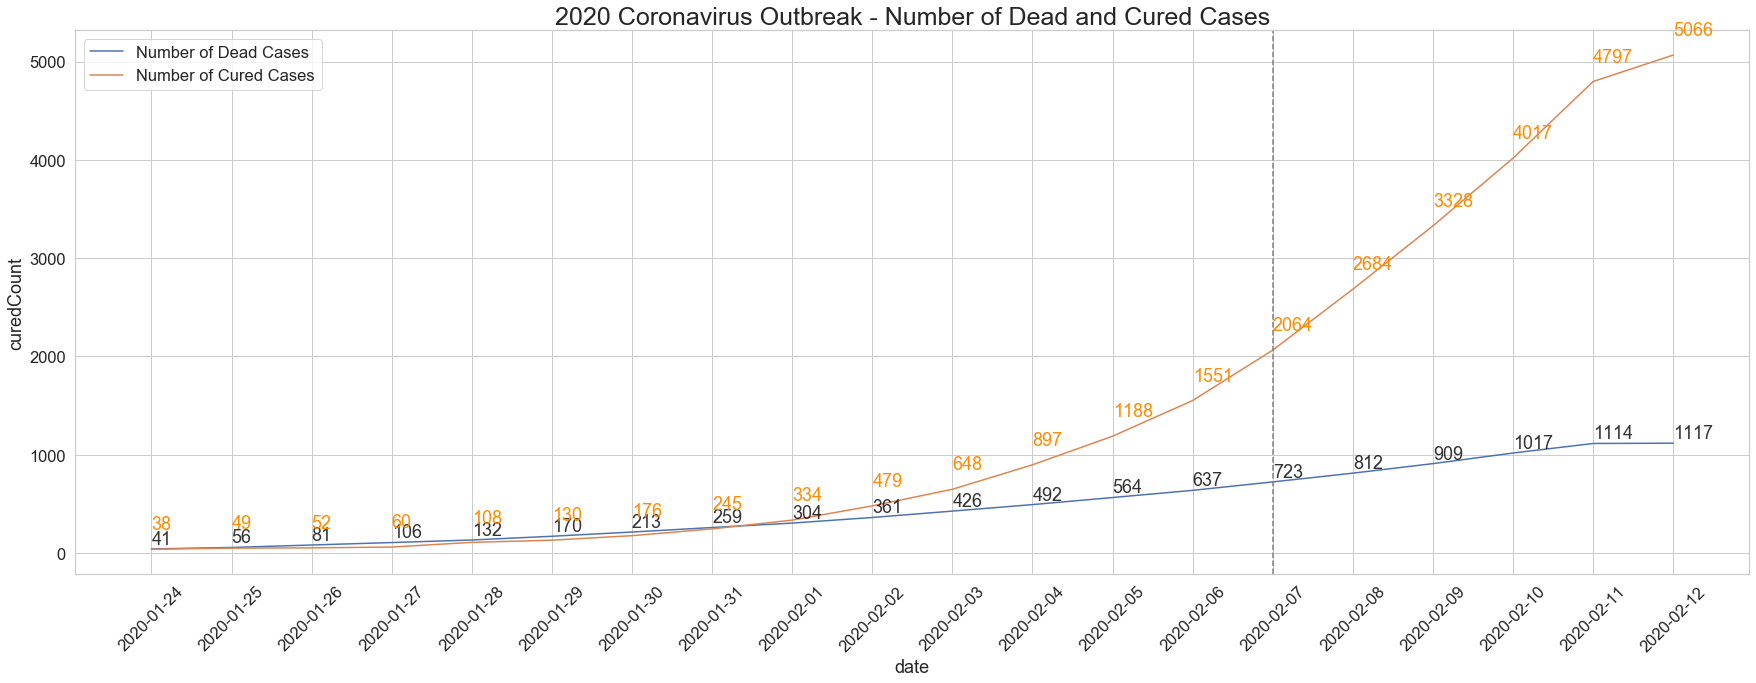

In [15]:
#plot dead cured
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_day['date'].astype(str), y=df_day['deadCount'], ax=ax1, label = 'Number of Dead Cases').set_title('2020 Coronavirus Outbreak - Number of Dead and Cured Cases', fontsize=25)
sns.lineplot(x=df_day['date'].astype(str), y=df_day['curedCount'], ax=ax1, label = 'Number of Cured Cases')
# add data label
[ax1.text(p[0], p[1]+50, p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['deadCount'])]
[ax1.text(p[0], p[1]+200, p[1], color='darkorange', alpha=1) for p in zip(ax1.get_xticks(), df_day['curedCount'])];
# 14 days lag of outbreak
ax1.axvline(str(df_day['date'][0] + timedelta(days=14)),color='grey', linestyle = '--');

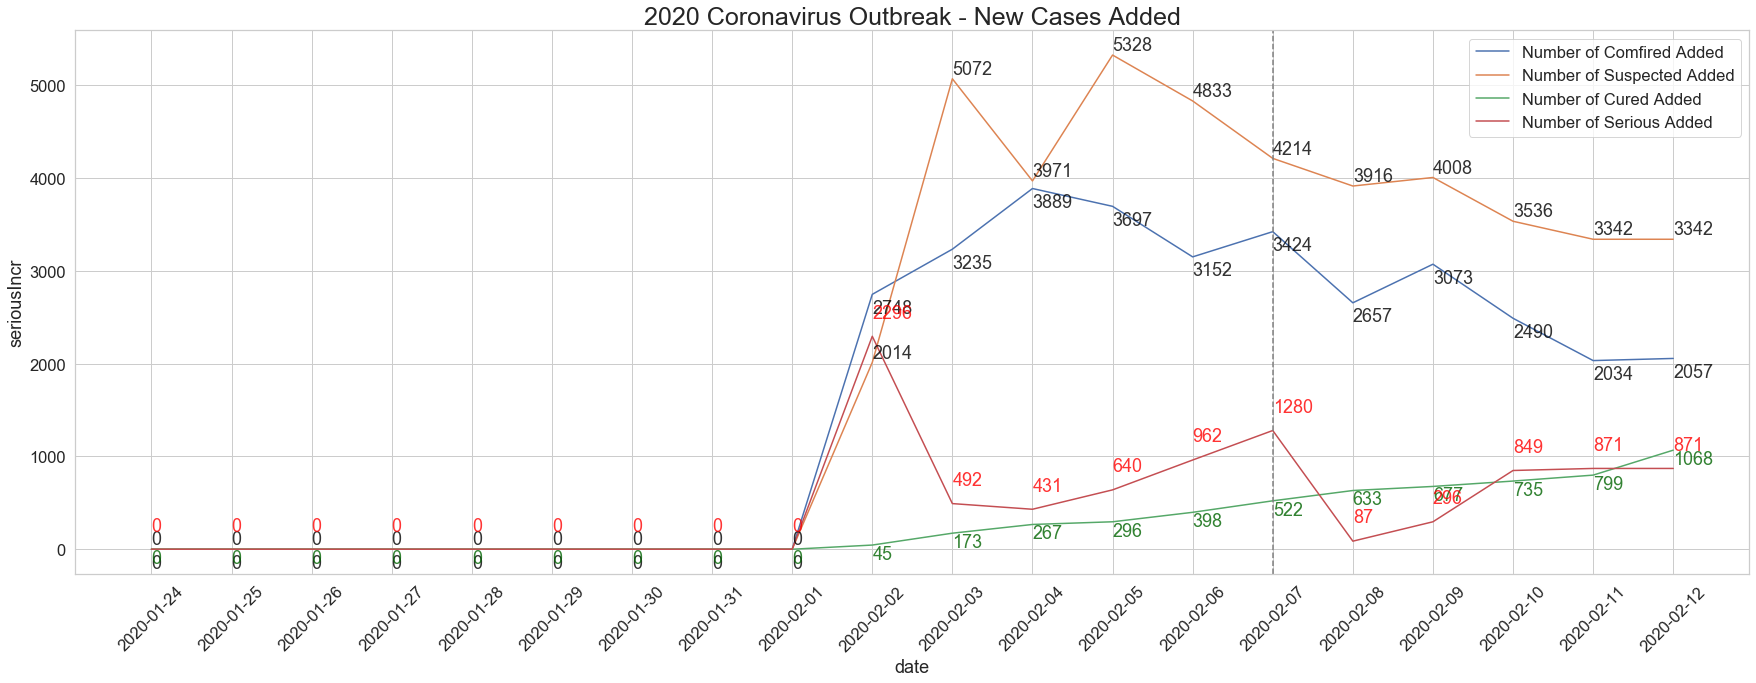

In [16]:
#plot dead cured 
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_day['date'].astype(str), y=df_day['confirmedIncr'], ax=ax1, label = 'Number of Comfired Added').set_title('2020 Coronavirus Outbreak - New Cases Added', fontsize=25)
sns.lineplot(x=df_day['date'].astype(str), y=df_day['suspectedIncr'], ax=ax1, label = 'Number of Suspected Added')
sns.lineplot(x=df_day['date'].astype(str), y=df_day['curedIncr'], ax=ax1, label = 'Number of Cured Added')
sns.lineplot(x=df_day['date'].astype(str), y=df_day['seriousIncr'], ax=ax1, label = 'Number of Serious Added')
# add data label
[ax1.text(p[0], p[1]-200, p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['confirmedIncr'])]
[ax1.text(p[0], p[1]+50, p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['suspectedIncr'])]
[ax1.text(p[0], p[1] - 150, p[1], color='darkgreen', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['curedIncr'])];
[ax1.text(p[0], p[1]+200, p[1], color='red', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['seriousIncr'])];
# 14 days lag of outbreak
ax1.axvline(str(df_day['date'][0] + timedelta(days=14)),color='grey', linestyle = '--');

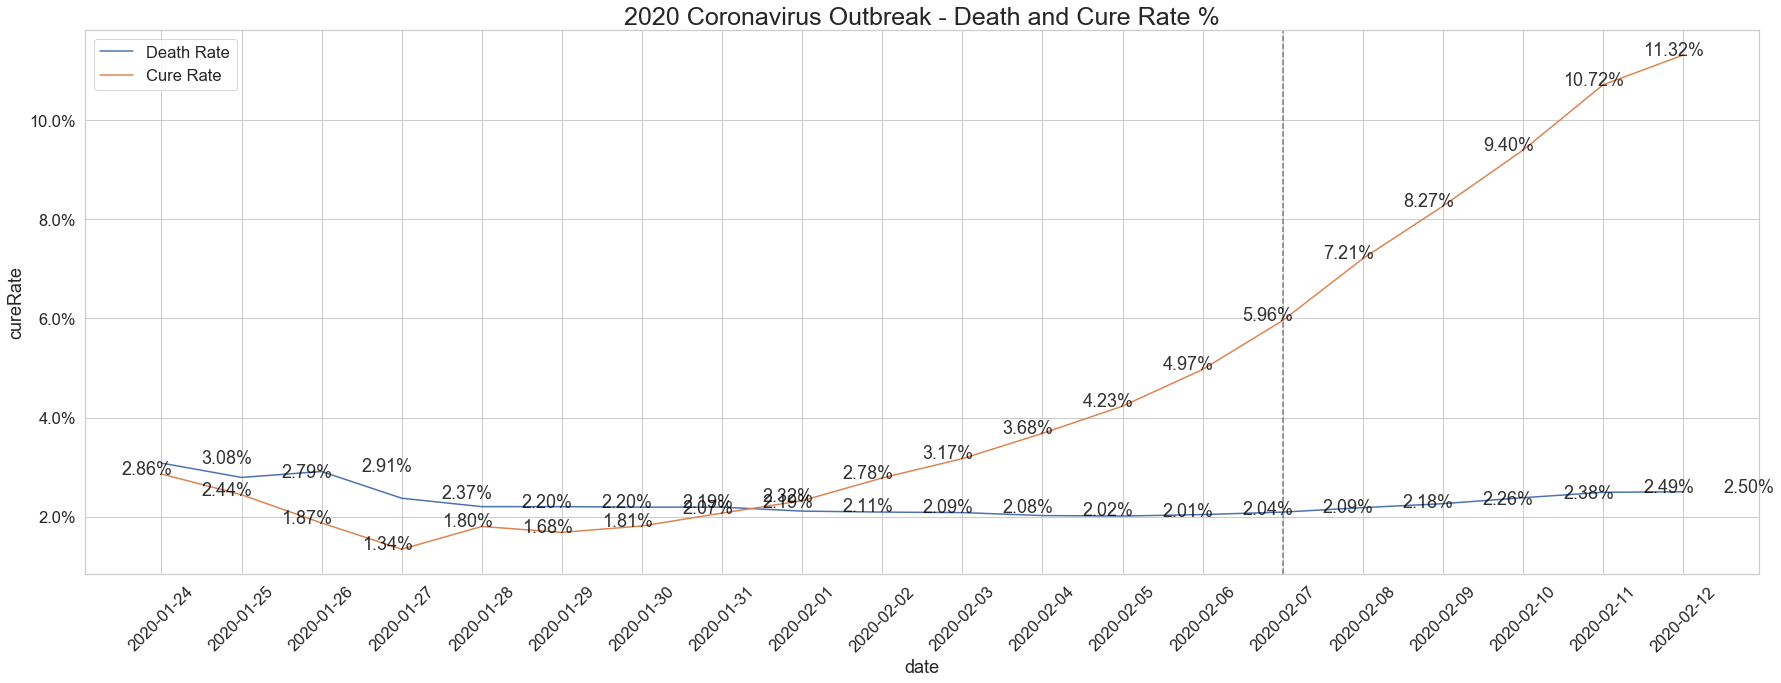

In [17]:
#plot dead cured
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_day['date'].astype(str), y=df_day['deathRate'], ax=ax1, label = 'Death Rate').set_title('2020 Coronavirus Outbreak - Death and Cure Rate %', fontsize=25);
sns.lineplot(x=df_day['date'].astype(str), y=df_day['cureRate'], ax=ax1, label = 'Cure Rate')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# add data label
[ax1.text(p[0]+ 0.5, p[1], '{:,.2%}'.format(p[1]), color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['deathRate'])];
[ax1.text(p[0]-0.5, p[1], '{:,.2%}'.format(p[1]), color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['cureRate'])];

# # 14 days lag of outbreak
ax1.axvline(str(df_day['date'][0] + timedelta(days=14)),color='grey', linestyle = '--');

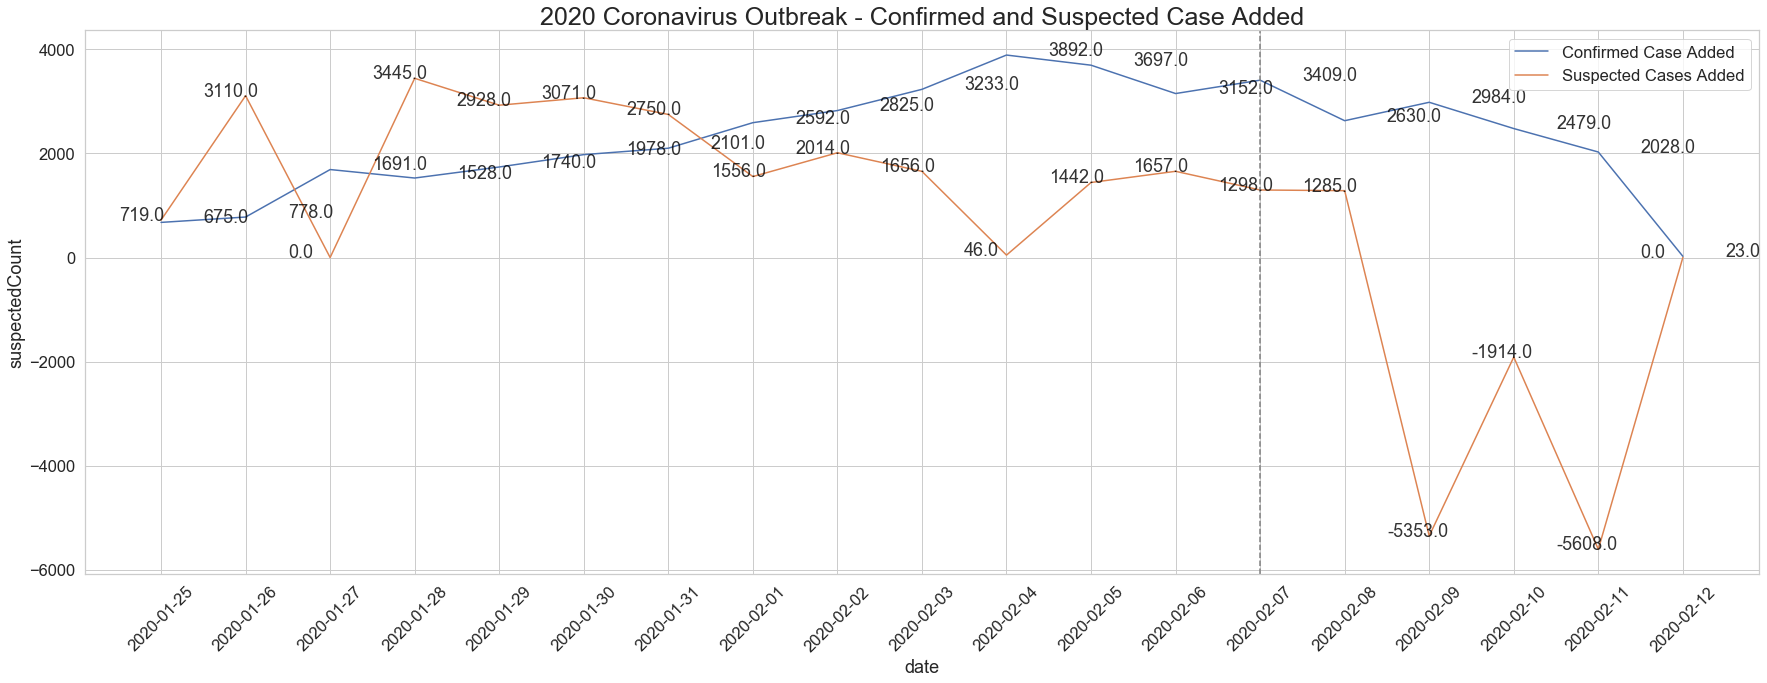

In [18]:
#plot dead cured
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_day.iloc[1:,0].astype(str), y=df_day.diff()['confirmedCount'], ax=ax1, label = 'Confirmed Case Added').set_title('2020 Coronavirus Outbreak - Confirmed and Suspected Case Added', fontsize=25);
sns.lineplot(x=df_day.iloc[1:,0].astype(str), y=df_day.diff()['suspectedCount'], ax=ax1, label = 'Suspected Cases Added')
# add data label
[ax1.text(p[0]+ 0.5, p[1], p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day.diff().iloc[1:,1])];
[ax1.text(p[0]-0.5, p[1], p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day.diff().iloc[1:,2])];

# # 14 days lag of outbreak
ax1.axvline(str(df_day['date'][0] + timedelta(days=14)),color='grey', linestyle = '--');

### CoronaVirus State Level Cases

In [31]:
# access apl
api = 'https://lab.isaaclin.cn/nCoV/api/area'
par = {'latest': '0'}
result =requests.get(api, params=par)
result.status_code

200

In [20]:
data = result.json()['results']
len(data)

7235

In [32]:
# get all location name
provinces = []
countries = []
confirmedCount =[]
suspectedCount =[]
curedCount =[]
deadCount =[]
updateTime =[]
for i in range(len(data)):
    provinces.append(data[i]['provinceName'])
    countries.append(data[i]['country'])
    confirmedCount.append(data[i]['confirmedCount'])
    suspectedCount.append(data[i]['suspectedCount'])
    curedCount.append(data[i]['curedCount'])
    deadCount.append(data[i]['deadCount'])
    updateTime.append(data[i]['updateTime'])

In [33]:
# create a df
df_byarea = pd.DataFrame(list(zip(provinces, countries, confirmedCount, suspectedCount, curedCount, deadCount, updateTime)),
            columns=['provinces', 'country', 'confirmedCount', 'suspectedCount', 'curedCount', 'deadCount', 'updateTime'])
# change date formate
df_byarea['updateTime'] = pd.to_datetime(df_byarea['updateTime'], unit='ms')

In [34]:
# areas and dates they report
areas = df_byarea[df_byarea['country'] == '中国']['provinces'].unique()
dates = df_byarea['updateTime'].dt.date.unique()
#index for laste update of each area
ix_lastUpdate = []
# find latest report time for each area
for a in areas:
    for date in dates:
        try:
            # time of last update
            last_update = df_byarea[(df_byarea['provinces'] ==a) & 
                                    (df_byarea['updateTime'].dt.date ==date)]['updateTime'].max()
            ix = df_byarea[(df_byarea['provinces'] == a) & (df_byarea['updateTime'] == last_update)].index.values[0]
            ix_lastUpdate.append(ix)
        except IndexError:
            pass

In [35]:
# last report of each day
df_byarea_byday = df_byarea.loc[ix_lastUpdate]
# change the formate of date
df_byarea_byday['updateTime'] = df_byarea_byday['updateTime'].dt.date
# most dont have suspectedcount by area
df_byarea_byday.head()

,provinces,country,confirmedCount,suspectedCount,curedCount,deadCount,updateTime
0,天津市,中国,113,0.0,11,3,2020-02-13
827,天津市,中国,112,0.0,11,2,2020-02-12
2558,天津市,中国,106,0.0,10,2,2020-02-11
4406,天津市,中国,95,0.0,8,1,2020-02-10
4660,天津市,中国,91,0.0,4,1,2020-02-09


In [45]:
df_hubei.merge(df_byarea_byday[df_byarea_byday['provinces']=='湖北省'].sort_values(by='updateTime'), how='inner',
              left_on='updateTime', right_on='updateTime').head()

,updateTime,confirmedCount_x,curedCount_x,deadCount_x,provinces,country,confirmedCount_y,suspectedCount,curedCount_y,deadCount_y
0,2020-01-21,51,0,0,湖北省,中国,270,11.0,25,6
1,2020-01-22,105,0,0,湖北省,中国,444,NaN,28,17
2,2020-01-23,205,0,1,湖北省,中国,444,0.0,0,0
3,2020-01-24,381,5,2,湖北省,中国,729,0.0,32,39
4,2020-01-25,602,7,2,湖北省,中国,761,0.0,32,40


In [58]:
# create a df to compare hubei and non-hubei cases
df_hubei = df_byarea_byday[df_byarea_byday['provinces']!='湖北省'].groupby('updateTime').sum()[['confirmedCount', 'curedCount', 'deadCount']].reset_index()
df_hubei= df_hubei.merge(df_byarea_byday[df_byarea_byday['provinces']=='湖北省'].sort_values(by='updateTime'), how='inner', 
                         left_on='updateTime', right_on='updateTime')
# change the column names
df_hubei.rename(columns={'confirmedCount_x': 'nonHubei_comfirmedCount',
                        'curedCount_x': 'nonHubei_curedCount',
                        'deadCount_x': 'nonHubei_deadCount',
                        'confirmedCount_y': 'Hubei_comfirmedCount',
                        'curedCount_y': 'Hubei_curedCount',
                        'deadCount_y': 'Hubei_deadCount'}, inplace=True)
df_hubei.drop(['provinces', 'country','suspectedCount'], inplace=True, axis=1)
df_hubei.head()

,updateTime,nonHubei_comfirmedCount,nonHubei_curedCount,nonHubei_deadCount,Hubei_comfirmedCount,Hubei_curedCount,Hubei_deadCount
0,2020-01-21,51,0,0,270,25,6
1,2020-01-22,105,0,0,444,28,17
2,2020-01-23,205,0,1,444,0,0
3,2020-01-24,381,5,2,729,32,39
4,2020-01-25,602,7,2,761,32,40


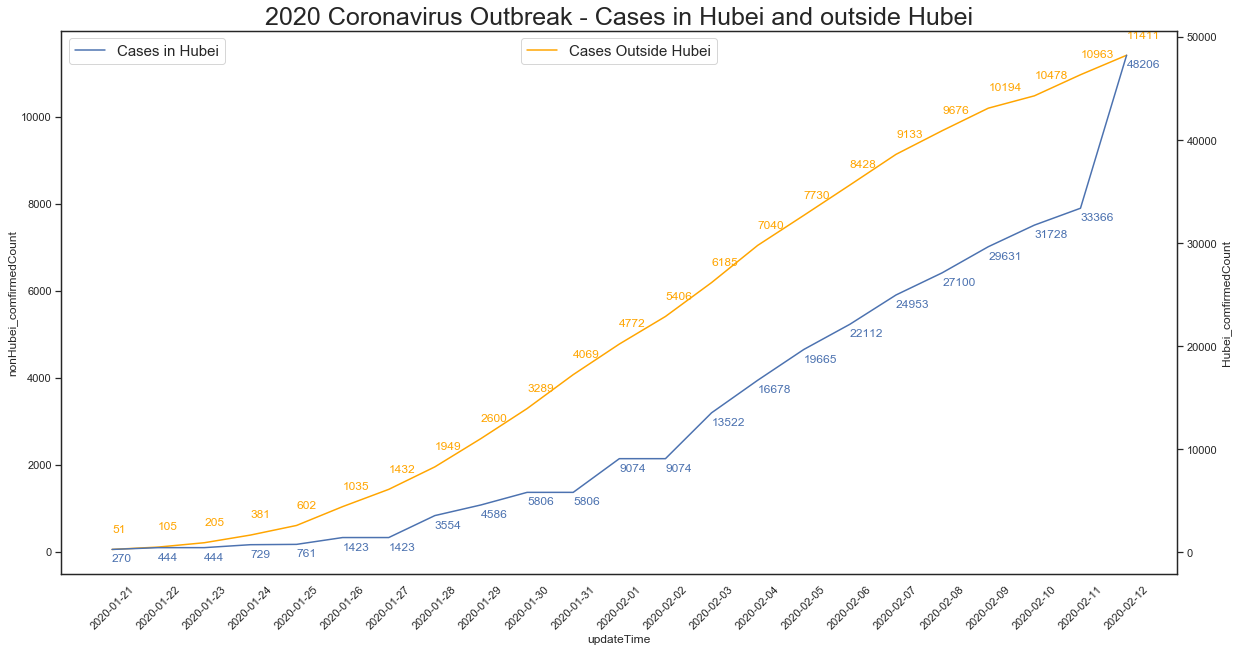

In [59]:
#plot
sns.set(style='white')
f, (ax1) = plt.subplots(figsize=(20,10))
# rotate each xaxis tick
plt.xticks(rotation=45)

ax2 = ax1.twinx()
sns.lineplot(x=df_hubei['updateTime'].astype(str), y=df_hubei['nonHubei_comfirmedCount'],  ax=ax1, label='Cases Outside Hubei', color='orange').set_title('2020 Coronavirus Outbreak - Cases in Hubei and outside Hubei', fontsize=25);
sns.lineplot(x=df_hubei['updateTime'].astype(str), y=df_hubei['Hubei_comfirmedCount'], ax=ax2, label='Cases in Hubei', )
ax1.legend(loc=9,prop={'size': 15})
ax2.legend(loc=2,prop={'size': 15})
[ax1.text(p[0], p[1]+400, p[1], color='orange', alpha=1) for p in zip(ax1.get_xticks(), df_hubei['nonHubei_comfirmedCount'])];
[ax2.text(p[0], p[1]-1200, p[1], color='b', alpha=1) for p in zip(ax2.get_xticks(), df_hubei['Hubei_comfirmedCount'])];

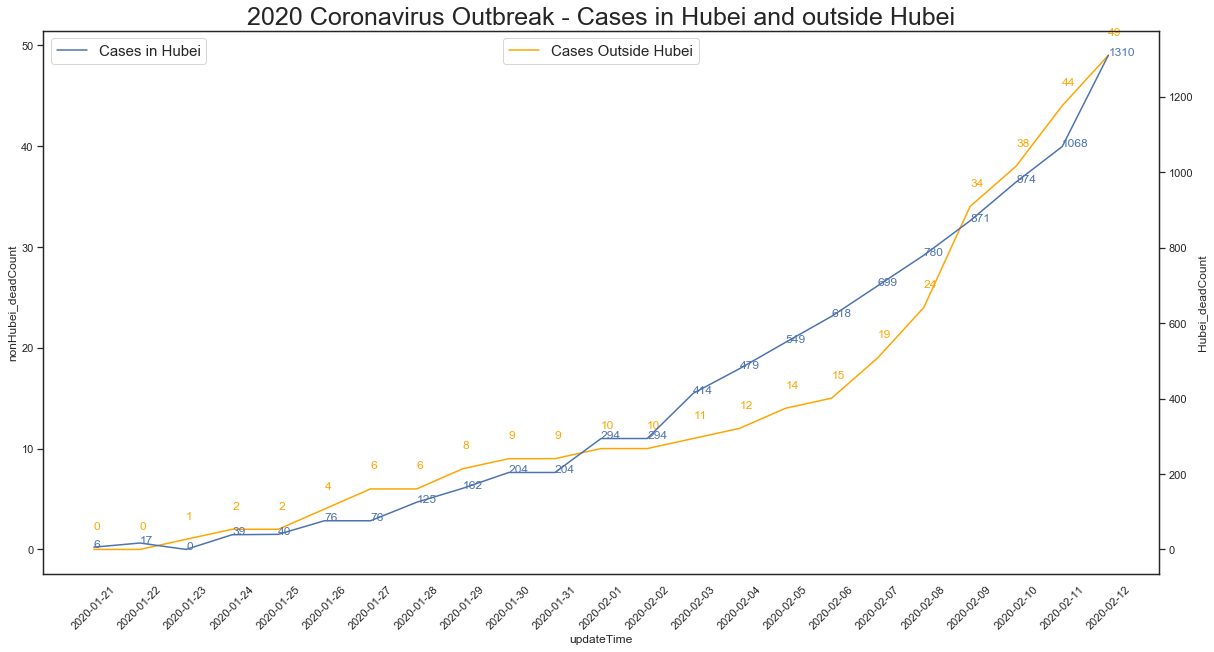

In [71]:
#plot
sns.set(style='white')
f, (ax1) = plt.subplots(figsize=(20,10))
# rotate each xaxis tick
plt.xticks(rotation=45)

ax2 = ax1.twinx()
sns.lineplot(x=df_hubei['updateTime'].astype(str), y=df_hubei['nonHubei_deadCount'],  ax=ax1, label='Cases Outside Hubei', color='orange').set_title('2020 Coronavirus Outbreak - Cases in Hubei and outside Hubei', fontsize=25);
sns.lineplot(x=df_hubei['updateTime'].astype(str), y=df_hubei['Hubei_deadCount'], ax=ax2, label='Cases in Hubei', )
ax1.legend(loc=9,prop={'size': 15})
ax2.legend(loc=2,prop={'size': 15})
[ax1.text(p[0], p[1]+2, p[1], color='orange', alpha=1) for p in zip(ax1.get_xticks(), df_hubei['nonHubei_deadCount'])];
[ax2.text(p[0], p[1], p[1], color='b', alpha=1) for p in zip(ax2.get_xticks(), df_hubei['Hubei_deadCount'])];

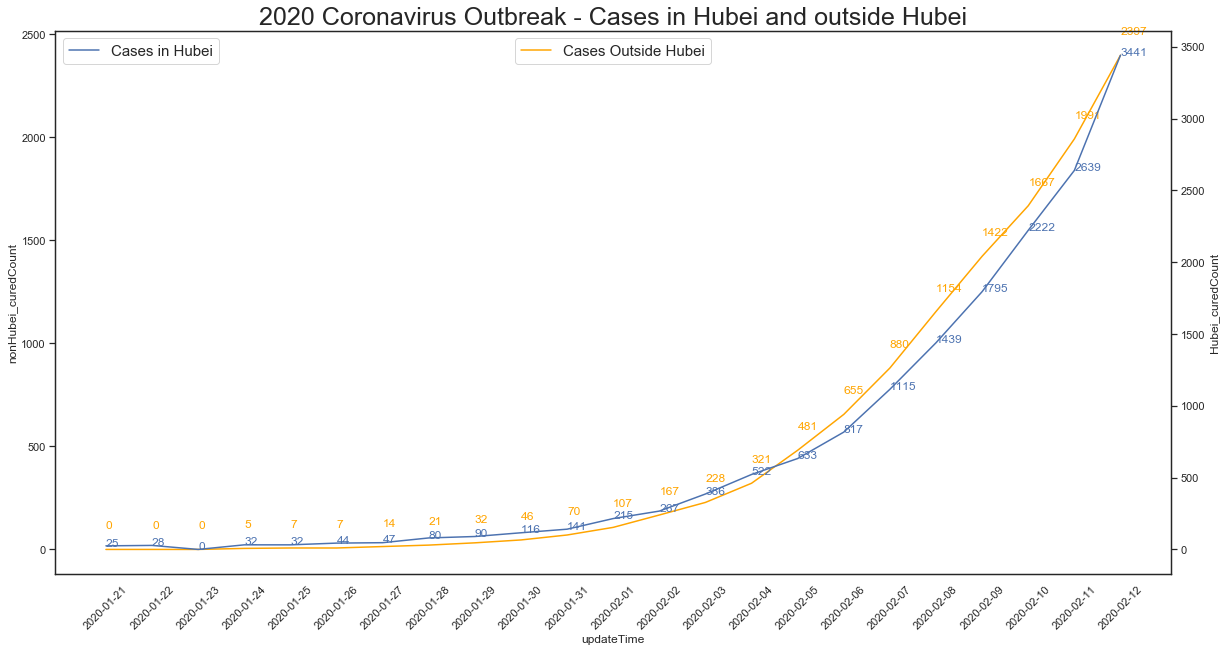

In [73]:
#plot
sns.set(style='white')
f, (ax1) = plt.subplots(figsize=(20,10))
# rotate each xaxis tick
plt.xticks(rotation=45)

ax2 = ax1.twinx()
sns.lineplot(x=df_hubei['updateTime'].astype(str), y=df_hubei['nonHubei_curedCount'],  ax=ax1, label='Cases Outside Hubei', color='orange').set_title('2020 Coronavirus Outbreak - Cases in Hubei and outside Hubei', fontsize=25);
sns.lineplot(x=df_hubei['updateTime'].astype(str), y=df_hubei['Hubei_curedCount'], ax=ax2, label='Cases in Hubei', )
ax1.legend(loc=9,prop={'size': 15})
ax2.legend(loc=2,prop={'size': 15})
[ax1.text(p[0], p[1]+100, p[1], color='orange', alpha=1) for p in zip(ax1.get_xticks(), df_hubei['nonHubei_curedCount'])];
[ax2.text(p[0], p[1], p[1], color='b', alpha=1) for p in zip(ax2.get_xticks(), df_hubei['Hubei_curedCount'])];

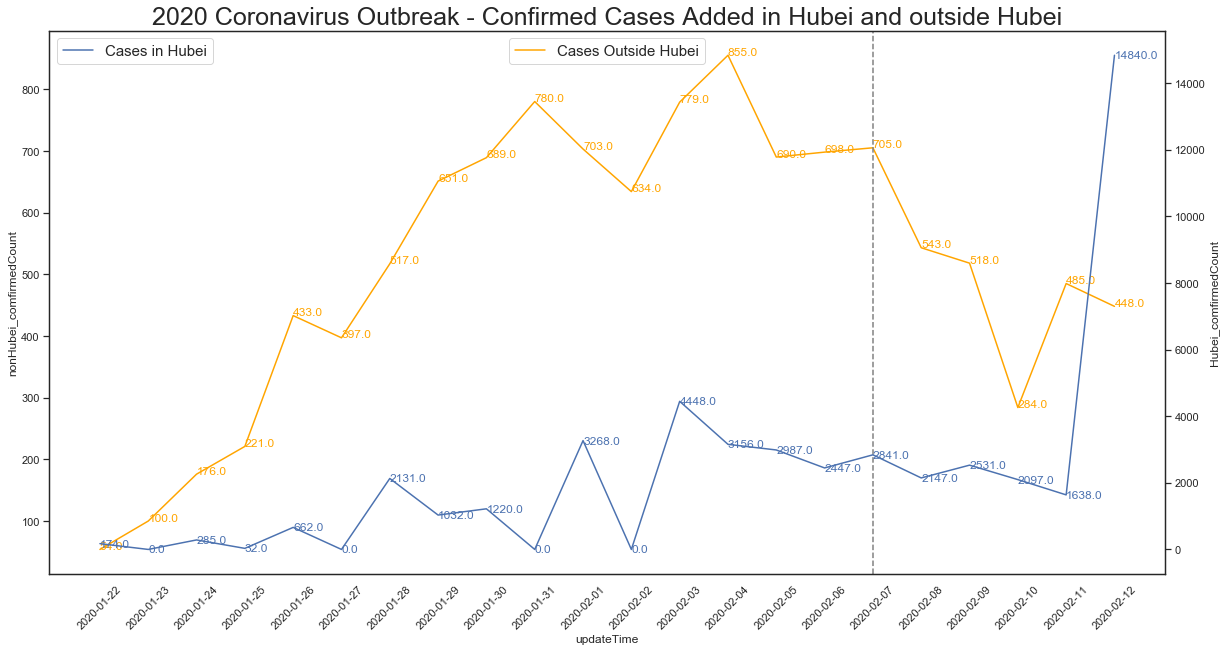

In [60]:
#plot
sns.set(style='white')
f, (ax1) = plt.subplots(figsize=(20,10))
# rotate each xaxis tick
plt.xticks(rotation=45)

ax2 = ax1.twinx()
sns.lineplot(x=df_hubei.loc[1:,'updateTime'].astype(str), y=df_hubei.diff()['nonHubei_comfirmedCount'],  ax=ax1, label='Cases Outside Hubei', color='orange').set_title('2020 Coronavirus Outbreak - Confirmed Cases Added in Hubei and outside Hubei', fontsize=25);
sns.lineplot(x=df_hubei.loc[1:,'updateTime'].astype(str), y=df_hubei.diff()['Hubei_comfirmedCount'], ax=ax2, label='Cases in Hubei', )
ax1.legend(loc=9,prop={'size': 15})
ax2.legend(loc=2,prop={'size': 15})
[ax1.text(p[0], p[1], p[1], color='orange', alpha=1) for p in zip(ax1.get_xticks(), df_hubei.diff().loc[1:,'nonHubei_comfirmedCount'])];
[ax2.text(p[0], p[1]-100, p[1], color='b', alpha=1) for p in zip(ax2.get_xticks(), df_hubei.diff().loc[1:, 'Hubei_comfirmedCount'])];
# # 14 days lag of outbreak
ax1.axvline(str(df_day['date'][0] + timedelta(days=14)),color='grey', linestyle = '--');

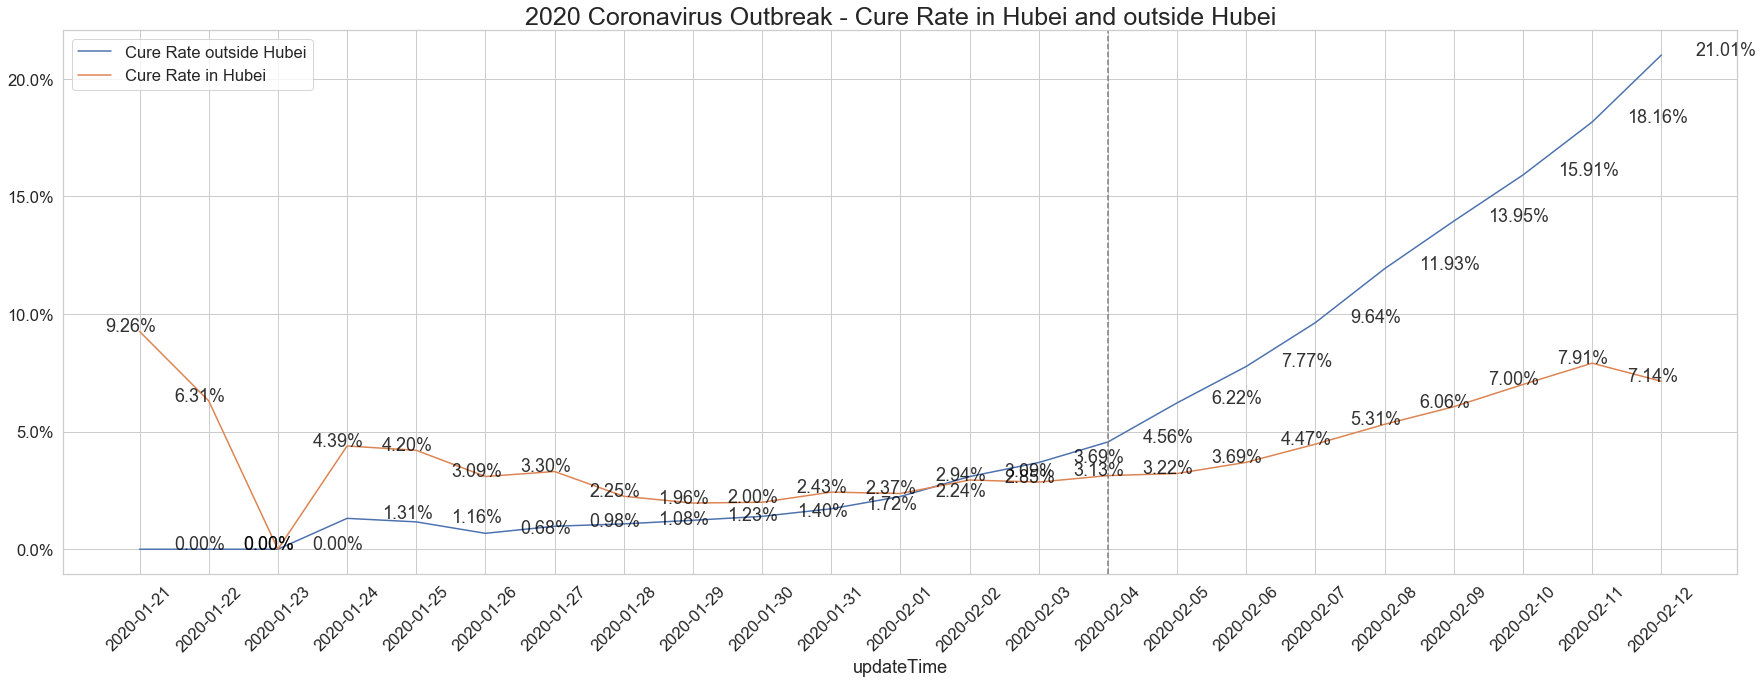

In [61]:
#plot dead cured
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_hubei['updateTime'].astype(str), y=df_hubei['nonHubei_curedCount']/df_hubei['nonHubei_comfirmedCount'], ax=ax1, label = 'Cure Rate outside Hubei').set_title('2020 Coronavirus Outbreak - Cure Rate in Hubei and outside Hubei', fontsize=25);
sns.lineplot(x=df_hubei['updateTime'].astype(str), y=df_hubei['Hubei_curedCount']/df_hubei['Hubei_comfirmedCount'], ax=ax1, label = 'Cure Rate in Hubei')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# add data label
[ax1.text(p[0]+ 0.5, p[1], '{:,.2%}'.format(p[1]), color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_hubei['nonHubei_curedCount']/df_hubei['nonHubei_comfirmedCount'])];
[ax1.text(p[0]-0.5, p[1], '{:,.2%}'.format(p[1]), color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_hubei['Hubei_curedCount']/df_hubei['Hubei_comfirmedCount'])];

# # 14 days lag of outbreak
ax1.axvline(str(df_hubei['updateTime'][0] + timedelta(days=14)),color='grey', linestyle = '--');

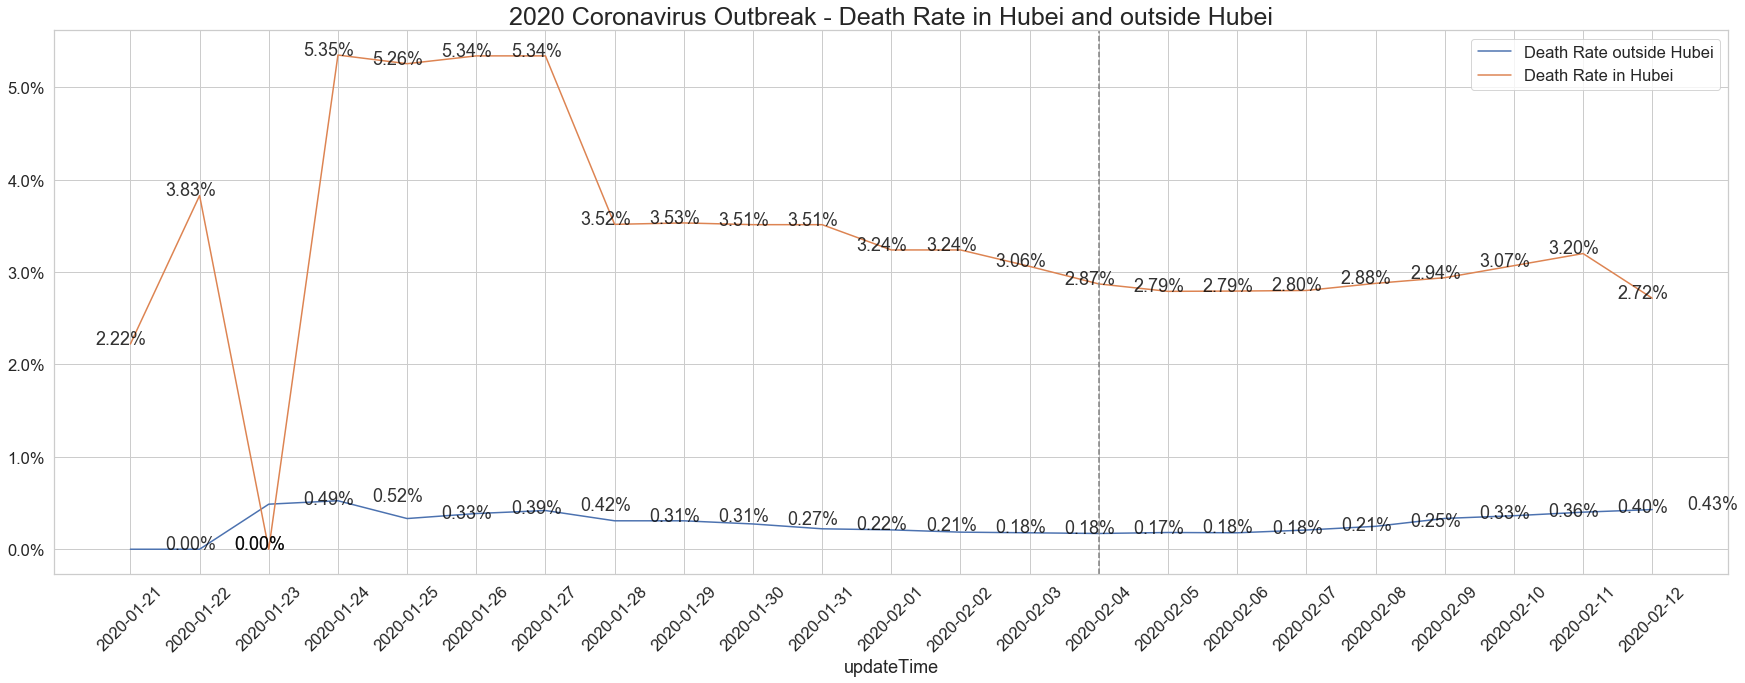

In [63]:
#plot dead cured
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_hubei['updateTime'].astype(str), y=df_hubei['nonHubei_deadCount']/df_hubei['nonHubei_comfirmedCount'], ax=ax1, label = 'Death Rate outside Hubei').set_title('2020 Coronavirus Outbreak - Death Rate in Hubei and outside Hubei', fontsize=25);
sns.lineplot(x=df_hubei['updateTime'].astype(str), y=df_hubei['Hubei_deadCount']/df_hubei['Hubei_comfirmedCount'], ax=ax1, label = 'Death Rate in Hubei')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# add data label
[ax1.text(p[0]+ 0.5, p[1], '{:,.2%}'.format(p[1]), color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_hubei['nonHubei_deadCount']/df_hubei['nonHubei_comfirmedCount'])];
[ax1.text(p[0]-0.5, p[1], '{:,.2%}'.format(p[1]), color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_hubei['Hubei_deadCount']/df_hubei['Hubei_comfirmedCount'])];

# # 14 days lag of outbreak
ax1.axvline(str(df_hubei['updateTime'][0] + timedelta(days=14)),color='grey', linestyle = '--');